# Assignment

We build on the feature engineering we did in the last assignment and run k-means on the data with RFM features in order to do **customer segmentation**. Since k-means is unsupervised, we will also encounter challenges around interpreting results at the end. 

In [1]:
import pandas as pd
col_names = ['user_id', 'gender', 'address', 'store_id', 'trans_id', 'timestamp', 'item_id', 'quantity', 'dollar']
churn = pd.read_csv("../data/retail-churn.csv", sep = ",", skiprows = 1, names = col_names)
churn.head()

,user_id,gender,address,store_id,trans_id,timestamp,item_id,quantity,dollar
0,101981,F,E,2860,818463,11/1/2000 0:00,4.710000e+12,1,37
1,101981,F,E,2861,818464,11/1/2000 0:00,4.710000e+12,1,17
2,101981,F,E,2862,818465,11/1/2000 0:00,4.710000e+12,1,23
3,101981,F,E,2863,818466,11/1/2000 0:00,4.710000e+12,1,41
4,101981,F,E,2864,818467,11/1/2000 0:00,4.710000e+12,8,288


Run the feature engineering steps on the data to extract RFM features.  

In [2]:
churn['date'] =  pd.to_datetime(pd.to_datetime(churn['timestamp'], format = '%m/%d/%Y %H:%M').dt.date)
churn_agg = churn.groupby(['user_id', 'date']).agg({'dollar': 'sum', 'quantity': 'sum'})
churn_agg = churn_agg.reset_index()
churn_roll = pd.DataFrame()
churn_roll['dollar_roll_sum_7D'] = churn_agg.groupby('user_id').rolling(window = '7D', on = 'date')['dollar'].sum()
churn_roll['quantity_roll_sum_7D'] = churn_agg.groupby('user_id').rolling(window = '7D', on = 'date')['quantity'].sum()
churn_roll = churn_roll.reset_index()
churn_roll['last_visit_ndays'] = churn_agg.groupby('user_id')['date'].diff(periods = 1).dt.days
print(churn_roll.shape)

# Should we impute or drop NaN/NaT in churn_roll['last_visit_ndays']?
imputation_value = churn_roll['last_visit_ndays'].max() # None # 
if imputation_value is None:
    # Drop (Remove all rows with NaN):
    churn_roll.dropna(inplace = True)
    print(churn_roll.shape)
else:
    # Impute (Replace all NaN in last_visit_ndays):
    churn_roll['last_visit_ndays'] = churn_roll['last_visit_ndays'].fillna(imputation_value)

churn_roll.head()

(37058, 5)


,user_id,date,dollar_roll_sum_7D,quantity_roll_sum_7D,last_visit_ndays
0,1113,2000-11-12,420.0,5.0,118.0
1,1113,2000-11-26,558.0,3.0,14.0
2,1113,2000-11-27,1182.0,9.0,1.0
3,1113,2001-01-06,628.0,9.0,40.0
4,1250,2001-02-04,734.0,5.0,118.0


The RFM features are:  'dollar_roll_sum_7D', 'quantity_roll_sum_7D', 'last_visit_ndays'

1. Train a k-means algorithm on the 3 normalized RFM features using $k = 10$. What are the cluster centroids? The cluster centroids should be reported in the **original scale**, not the normalized scale. <span style="color:red" float:right>[2 point]</span> 

In [3]:
import numpy as np
import seaborn as sns

import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.cluster import KMeans

In [4]:
# Add code here

# make user_id column categorical
churn_roll['user_id'] = churn_roll['user_id'].astype('category')
# select the numeric columns 
num_cols = churn_roll.select_dtypes(['integer', 'float']).columns

# normalized the columns
churn_roll_rescaled = churn_roll.copy()
churn_roll_rescaled = churn_roll_rescaled[num_cols].apply(lambda x: (x - x.mean()) / x.std(), axis = 0)


from sklearn.cluster import KMeans
n_clusters = 10 # the number of clusters (k)

X = churn_roll_rescaled
kmeans = KMeans(n_clusters = n_clusters, random_state = 0) # step 1: initialize
kmeans.fit(X) # step 2, learn the clusters
churn_roll_rescaled['cluster'] = kmeans.predict(X) # step 3, assign a cluster to each row


# add the user_ids back
user_ids = churn_roll['user_id']
churn_roll_rescaled['user_id'] = user_ids

# check
print(churn_roll_rescaled.head())

# centroids (for not normalized, use the original unscaled data)
print('scaled cluster centroids:')
ScaledCentroids = churn_roll[num_cols].groupby(by=kmeans.labels_).mean()
display(ScaledCentroids)
print('\nNumber of items in each cluster:')
print(churn_roll_rescaled.cluster.value_counts())

   dollar_roll_sum_7D  quantity_roll_sum_7D  last_visit_ndays  cluster user_id
0           -0.391981             -0.369906          1.555344        1    1113
1           -0.325514             -0.461485         -0.614750        8    1113
2           -0.024964             -0.186749         -0.886012        0    1113
3           -0.291798             -0.186749         -0.072227        8    1113
4           -0.240743             -0.369906          1.555344        1    1250
scaled cluster centroids:


,dollar_roll_sum_7D,quantity_roll_sum_7D,last_visit_ndays
0,832.947263,10.667705,6.805726
1,608.294594,7.270402,115.671027
2,10454.104730,68.591216,24.358108
3,19804.400000,972.800000,3.600000
4,30669.413043,172.586957,7.239130
5,4491.254889,41.294654,10.070404
6,2128.394128,22.626094,11.857476
7,62793.888889,156.222222,14.555556
8,369.222887,4.593226,23.797201
9,2717.173682,25.921142,114.514272



Number of items in each cluster:
cluster
0    9955
8    9359
1    8639
6    5143
9    2067
5    1534
2     296
4      46
3      10
7       9
Name: count, dtype: int64


2. Our earlier choice of $k=10$ was arbitrary. To find a better number of $k$ create a **scree plot**, which plots the number of clusters $k$ on the x-axis and the sum of squared distances from each point to its cluster centroid on the y-axis. We can get the latter by calling the `inertia_` attribute as shown in the lab. Plot the scree plot for $k$ values from 1 to 15. <span style="color:red" float:right>[4 point]</span>

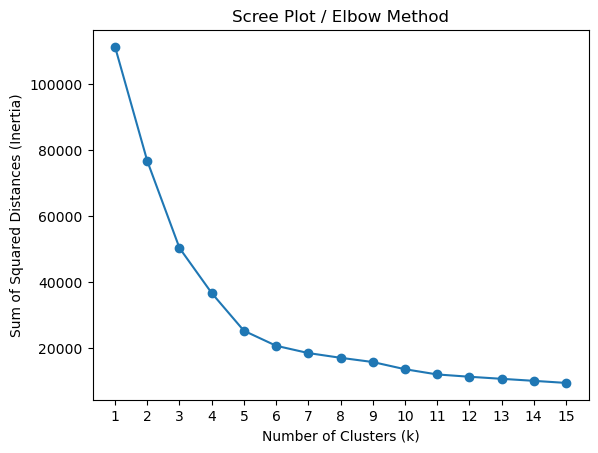

In [5]:
# Add code here
# select numeric columns for clustering
X = churn_roll_rescaled[num_cols]  # Use only the numeric features

# define range of k to try (1 to 15)
k_values = range(1, 16)  # 1 to 15 clusters
inertia_values = []       # To store sum of squared distances

# loop over k values
for k in k_values:
    kmeans = KMeans(n_clusters=k, random_state=0) # set seed
    kmeans.fit(X)
    inertia_values.append(kmeans.inertia_)

# plot the scree plot
plt.plot(k_values, inertia_values, marker='o')
plt.title('Scree Plot / Elbow Method')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Sum of Squared Distances (Inertia)')
plt.xticks(k_values)
plt.show()

3. Based on the scree plot, what is a good value to pick for $k$? Provide a brief justification for your choice. <span style="color:red" float:right>[2 point]</span>

**Add Comment here**   
Scree Plot is often referred as Elbow method, we want to find where the inertia stops decreasing drastically, this is visualized as the "elbow" part of the plot. In this case, 5 clusters would be a good pick for k. 

4. Train a k-means algorithm on the RFM features using your new value of $k$. Report:
- the size (number of items) of each cluster
- the mean of each cluster in the original scale
- the standard deviation of each cluster in the Z-normalized scale
<span style="color:red" float:right>[2 point]</span>

In [6]:
# Add code here
n_clusters = 5 # the number of clusters (k)

X = churn_roll_rescaled
kmeans = KMeans(n_clusters = n_clusters, random_state = 0) # step 1: initialize
kmeans.fit(X) # step 2, learn the clusters
churn_roll_rescaled['cluster'] = kmeans.predict(X) # step 3, assign a cluster to each row

# report the size of each cluster
print('\nNumber of items in each cluster:')
print(churn_roll_rescaled.cluster.value_counts())

# report the mean of each cluster in the original scale
# Make a copy of the original unscaled data
churn_roll_with_clusters = churn_roll.copy()
# Add the cluster labels learned from the normalized data
churn_roll_with_clusters['cluster'] = churn_roll_rescaled['cluster'].values

print('\nThe mean of each cluster in original scale:')
org_mean = churn_roll_with_clusters.groupby('cluster')[num_cols].mean()
display(org_mean)


# report the standard deviation of each cluster in the Z-normalized sacle
print('\nThe standard deviation of each cluster in the Z-normalized scale:')
std_z_normalized = churn_roll_rescaled.groupby('cluster')[num_cols].std()
display(std_z_normalized)



Number of items in each cluster:
cluster
0    11311
2    10212
4     5455
3     5161
1     4919
Name: count, dtype: int64

The mean of each cluster in original scale:


,dollar_roll_sum_7D,quantity_roll_sum_7D,last_visit_ndays
cluster,,,
0,1336.035806,13.786403,43.921758
1,1306.257573,14.226266,36.120350
2,1142.666667,12.035546,49.447219
3,1054.794807,11.637861,39.179810
4,1296.649863,13.890742,41.971769



The standard deviation of each cluster in the Z-normalized scale:


,dollar_roll_sum_7D,quantity_roll_sum_7D,last_visit_ndays
cluster,,,
0,0.887850,0.691813,1.002996
1,1.031233,0.897468,0.945743
2,1.247670,1.542579,1.031207
3,0.600057,0.497487,0.963229
4,0.963385,0.609990,0.986925


5. Pick 3 clusters at random and describe what makes them different from one another (in terms of their RFM features). <span style="color:red" float:right>[3 point]</span>

**Add Comment here**  

Cluster 0 is high values, high quantity, average recency spenders. This cluster has the highest spending, relatively high purchase quantity and moderate in days from last visits.  
Cluster 2 is moderate values, low quantity and high recency spenders. This cluster spends relatively moderately with moderate purchase qunatity but has the lowest recency, which means it has a longer time since the last visit comparing to other clusters.  
Cluster 3  is low values, low quantity and low recency spenders. This cluster is the lowest spending with lowest purchase quantity of all clusters but it has the second lowest recency, meaning users in this group visits more often. 

# End of assignment